# IMPORTS

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, emcee, corner, mpld3
import pandas as pd, numpy as np
from scipy.stats import norm
from scipy.integrate import odeint
from scipy import optimize
from scipy import integrate
from IPython.display import display, Math, Latex
import numpy as np
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt

# Fixed Variables

In [41]:
KD = 129
KD_SAv = 76
Bmax = 2500
Bmax_SAv = 2964

# Start Parallel for MCMC Hammer

In [43]:
from IPython import parallel
#from IPython import ipyparallel
c = parallel.Client()
view = c.load_balanced_view()

In [44]:
#%%px --local

import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm

####

####=============================PRINT ERRORS???? 0 = No, 1 = Yes===================================================
ERROR = 0

####


# Design the System of Equations

In [52]:
%%px --local
def core(y, t, params):
    #    
    KD = 129
    Bmax = 2500

    x1,x2,x3,x4,x5,x6 = y
    kt,kon,ke,kex,kdi,kde = params
    koff = kon*KD
    return [
        kt*Bmax - kt*x1 - kon*x1*x2 + koff*x3 + kex*x4,
        -kon*x1*x2 + koff*x3 + kex*x4,
        kon*x1*x2 - koff*x3 - ke*x3,
        ke*x3 - kex*x4 - kdi*x4 - kde*x4,
        kdi*x4,
        kde*x4
    ]

def aux(y, t, params):
    #print y
    KD_SAv = 76
    Bmax_SAv = 2964
    x7,x8,x9,x10,x11,x12 = y
    kt,kon_SAv,kex_SAv,kdi,kde = params
    koff_SAv = kon_SAv*KD_SAv
    return [
        kt*Bmax_SAv - kt*x7 - kon_SAv*x7*x8 + koff_SAv*x9,
        -kon_SAv*x7*x8 + koff_SAv*x9 + kex_SAv*x10,
        kon_SAv*x7*x8 - koff_SAv*x9 - kt*x9,
        kt*x9 - kex_SAv*x10 - kdi*x10 - kde*x10,
        kdi*x10,
        kde*x10      
    ]
    

# Design the Model

In [48]:
%%px --local
from scipy.integrate import odeint
def model(yca, t, params):
    ### yca contains all initial values for core and aux systems
    ### 
    ### yca is divided into yc0 and ya0 (the initial values 
    ### for core and aux systems respectively)
    ### 
    ### yc0 and ya0 are updated through the ODE step process
    ###
    ### params contains all parameters for core and aux models
    ### params = (shared vars) (aux only vars)   (core only vars)
    ### params = kt,kdi,kde,kon_SAv,kex_Sav,kmob,kon,ke,kex
    ### auxparams = (aux vars)
    ### coreparams = (core vars)
    
    yc0 = yca[:6]
    ya0 = yca[6:]
    
    kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex = params
    auxparams = [kt,kon_SAv,kex_Sav,kdi,kde]
    coreparams = [kt,kon,ke,kex,kdi,kde]
    
    output = []
    ti = [0,1]
    output.append(np.append(yc0,ya0))
    index = 0    
    for idx in range(len(t)-1):        
        
        
        # Solve
        yc = odeint(core, yc0, ti, args=(coreparams,))
        ya = odeint(aux, ya0, ti, args=(auxparams,))
        # Extract values for end of step
        resc = yc[1]
        resa = ya[1]

        # Numerical errors may result in very tiny values <0
        # set these back to 0
        output.append(np.append(resc,resa))
        yc0 = resc
        ya0 = resa
        # Update initial conditions for next step
        index += 1
    return np.array(output)


# Prepare the Model for MCMC Hammer

In [37]:
%%px --local
def log_likelihood(mcmc_params, xy0, obsDF):
    """ mcmc_params    Vector of parameters [m, kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex,Epo,SAv]
        xy0            Vector of initial conditions [x1,x3,x4,x5,x6,x7,x9,x10,x11,12]
        
        Returns the log likelihood.
    """   
    #convert DataFrame to list
    obs = []
    for name in obsDF.axes[1].values:
        obs.append(obsDF[name].values)
    time = obsDF.index.values
    
    #unpack Model Params and Initial Conditions
    model_params = mcmc_params[1:9]
    m = mcmc_params[0]
    yca=[]
    yca = np.append(xy0[0],mcmc_params[9])
    yca = np.append(yca,xy0[1:6])
    yca = np.append(yca,mcmc_params[10])
    yca = np.append(yca,xy0[6:])
    # Run deterministic model with these parameters
    y = model(yca, time, model_params)
    yT = y.T
    sim = []
    sim.append(yT[1] + yT[5])
    sim.append(yT[2])
    sim.append(yT[3]+yT[4])
    sim.append(yT[7]+yT[11])
    sim.append(yT[8])
    sim.append(yT[9]+yT[10])
    
    #print sim[1]
    # Calculate sigma_e for each step
    sigma_e = []
    for i in range(len(sim)):
        for j in range(len(sim[i])):
            if sim[i][j] == 0:
                sim[i][j] = 1e-11
        sigma_e.append(m*sim[i])
    #print Hsigma_e
    # Calculate log likelihood. For each element in the arrays sim, sigma_e and obs,
    # this code calculates the log prob of drawing 'obs' from a Gaussian centred on 
    # 'sim' with std. dev. 'sigma_e'. (See Section 2 of notebook 2 for explanation)
    n=len(sim)
    likes = []    
    for i in range(n):
        likes.append(-n*np.log(2*np.pi*sigma_e[i]**2)/2 - np.sum(((np.squeeze(np.asarray(obs[i] - sim[i])))**2)/(2*sigma_e[i]**2)))
        #likes.append(norm(sim[i], sigma_e[i]).logpdf(obs[i]))
        if np.any(np.isnan(likes[i]) == True):
            #print likesH
            #print "i inf"
            print "#########################################"
            print i
            print sigma_e[i]**2
            print np.log(2*np.pi*sigma_e[i]**2)
            print ((np.squeeze(np.asarray(obs[i] - sim[i])))**2)
            print 2*sigma_e[i]**2
            print "#########################################"
            print ""
    # If flow is zero, sigma_e is zero and scipy.norm returns NaN
    # Set these to -inf instead
    if 0:
        if np.any(np.isnan(likesH) == True):
            print likesH
            print "H inf"
        if np.any(np.isnan(likesL) == True):
            print likesL
            print "L inf"
    
    for i in range(n):
        likes[i][np.isnan(likes[i])] = -np.inf
    
    # Sum log likes
    ll = []
    for i in range(n):
        ll.append(np.sum(likes[i]))
    #print ll
    return ll

In [10]:
%%px --local
import numpy as np
def log_prior(mcmc_params,obs):
    """ mcmc_params    Vector of parameters [m, kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex,Epo,SAv]
    
        Returns the log prior probability of p
    """
    # Extract calibrating parameter values
    
    expEpo = obs["expEpo"].values[0]  #999.293
    expSAv = obs["expSAv"].values[0] #2030.19
    m, kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex,Epo,SAv = mcmc_params
    alltest = True
    if m <= 0 or m > 1:
        alltest = False
    for i in range(1,9):
        if mcmc_params[i] < 10e-7 or mcmc_params[i] > 10e3:
            alltest = False
    epop10 = expEpo + expEpo*.1
    epom10 = expEpo - expEpo*.1
    SAvp10 = expSAv + expSAv*.1
    SAvm10 = expSAv - expSAv*.1
    if Epo > epop10 or Epo < epom10:
        alltest = False
    if SAv > SAvp10 or SAv < SAvm10:
        alltest = False
    
    # If all parameters are within allowed ranges, return a constant 
    # (anything will do - I've used 0 here)
    # I know alpha should be a negative real number
    # I know all other values should be a real number and not nan or inf
    nan = np.any(np.isnan(mcmc_params) == True)
    inf = np.all(np.isfinite(mcmc_params) == True)
    real = np.all(np.isreal(mcmc_params) == True)
    
    if ((not nan) and inf and real and alltest):# and (amin <= b < bmax) and (amin <= r < rmax) and (amin <= c < cmax) and (amin <= v < vmax) and (0 <= m < mmax)):
        return 0
    # Else the parameter set is invalid (probability = 0; log prob = -inf)
    else:
        return -np.inf

In [11]:
%%px --local
def log_posterior(mcmc_params, xy0, obs):
    """ mcmc_params    Vector of parameters [m, kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex,Epo,SAv]
        met_df         Dataframe containing columns 'Rainfall_mm' and 'PET_mm', with datetime index
        
        Returns the log posterior.
    """   
    # Get log prior prob
    log_pri = log_prior(mcmc_params,obs)
    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(mcmc_params, xy0, obs)
        # Calculate log posterior
        #print log_like
        #return log_like
        post = []
        for log in log_like:
            post.append(log_pri+log)
        return post
    
    else:
        if 1:
            print "out of Range"
            print mcmc_params
        #likesH[np.isnan(likesH)] = -np.inf
        # Log prior is -inf, so log posterior is -inf too
        return [-np.inf, -np.inf]

# Function to Maximize Posterior

In [15]:
def neg_log_posterior(mcmc_params, xy0, obs):
    """ Negative of log posterior.
    """
    
    nlp = log_posterior(mcmc_params, xy0, obs)
    nlp = [x*-1 for x in nlp]
    #print nlp
    return np.sum(nlp)

def find_map(init_guess, xy0, obs):
    """ Estimate the location of the maximum of the posterior density.
    
            init_guess   Initial guess for starting optimiser
                         [alpha, T_s, T_g, m]
            met_df       Data frame of meteorological data
    """
    # Run optimiser
    if 0:
        param_est = optimize.fmin(neg_log_posterior, init_guess, args=(xy0, obs,),maxiter=10,full_output=1, disp=1, retall=1)

    else: 
        
        param_est = optimize.fmin(neg_log_posterior, init_guess, args=(xy0, obs,),maxiter=10)#,full_output=1, disp=1, retall=1)
    # https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html
    return param_est



# Function to Run MCMC Hammer

In [59]:
def run_mcmc(n_dim, n_walk, n_steps, n_burn, param_opt, obs, xy0, truths=None):
    """ Sample posterior using emcee.
    
            n_dim      Number of parameters being calibrated
            n_walk     Number of walkers/chains (must be even)
            n_steps    Number of steps taken by each walker
            n_burn     Number of steps to discard as "burn-in"
            param_opt  Optimised parameter set from find_map()
            truths     True values (if known) for plotting
        
        Produces plots of the chains and a 'corner plot' of the
        marginal posterior distribution.
        
        Returns an array of samples (with the burn-in discarded).
    """
    
    # Generate starting locations for the chains by adding a small
    # amount of Gaussian noise to optimised MAP
    starting_guesses = [param_opt + 1e-4*np.random.randn(n_dim) 
                        for i in range(n_walk)]

    # Prepare to sample. The params are automatically passed to log_posterior
    # as part of n_dim. "args" lists the other params that are also necessary
    # Note the poo=view argument, which tells emcee how to interface with our
    # "worker" processes
    sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior, 
                                    pool=view, args=[xy0, obs,])

    # Run sampler
    sampler_run = sampler.run_mcmc(starting_guesses, n_steps)

    # Print some stats. based on run properties
    print '\n'
    print 'Average acceptance fraction: ', np.mean(sampler.acceptance_fraction)
    #print 'Autocorrelation time: ', sampler.acor

    # Get results
    # Plot traces, including burn-in
    # a,b,r,c,m
    axes = ['m', 'kt','kdi','kde','kon_SAv','kex_Sav','kon','ke','kex','Epo','SAv']
    param_labels = [] #[r'$\ a$', r'$\ b$', r'$\ r$', r'$\ c$', r'$\ m$']
    for axe in axes:
        param_labels.append(r'$\ '+ axe + '$')
        
    fig, axes = plt.subplots(nrows=len(axes), ncols=1, figsize=(20, 20))    
    for idx, title in enumerate(param_labels):        
        axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
        axes[idx].set_title(title, fontsize=20) 
    plt.subplots_adjust(hspace=0.5)    
    plt.show()
    
    # Discard burn-in
    samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))
    
    # Triangle plot
    tri = corner.corner(samples,
                        labels=param_labels,
                        truths=truths,
                        quantiles=[0.025, 0.5, 0.975],
                        show_titles=True, 
                        title_args={'fontsize': 24},
                        label_kwargs={'fontsize': 20})
    
    return samples

# Functions to Evaluate Results

In [75]:
def get_uncertainty_intervals(n_sets, samples, obs, xy0):
    """ Get 95% credible intervals for parameter-related and predictive 
        uncertainty around the simulated median.
        
            n_sets      Number of parameters sets to sample
        
        Returns two data frames [param_only, overall]
        
            param_only  95% CI and median for parameter-related uncertainty
            overall     95% CI and median for overall predictive uncertainty
    """
    # Store output data in lists
    
    
    time = obs.index.values
    param_onlyEC = []
    param_onlyEM = []
    param_onlyES = []
    param_onlySC = []
    param_onlySM = []
    param_onlySS = []
    overallEC = []
    overallEM = []
    overallES = []
    overallSC = []
    overallSM = []
    overallSS = []
    # Pick parameter sets at random from the converged chains
    for m,kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex,Epo,SAv in samples[np.random.randint(len(samples), size=n_sets)]:
        # Reset initial conditions
        params = [kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex] # kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex
        # Run model
        yca=[]
        yca = np.append(xy0[0],Epo)
        yca = np.append(yca,xy0[1:6])
        yca = np.append(yca,SAv)
        yca = np.append(yca,xy0[6:])
        #sim = model(xy0, time, params)
        y = model(yca, time, params)
        yT = y.T
        sim = []
        sim.append(yT[1] + yT[5])
        sim.append(yT[2])
        sim.append(yT[3]+yT[4])
        sim.append(yT[7]+yT[11])
        sim.append(yT[8])
        sim.append(yT[9]+yT[10])
        
        d= {
            'EpoInCells': sim[0], 'EpoInMedium': sim[1], 'EpoOnSurface': sim[2], 
            'SAvInCells': sim[3], 'SAvInMedium': sim[4], 'SAvOnSurface': sim[5]
            }
        df = pd.DataFrame(data=d, index=time)

        # Discard burn-in
        #df = df.truncate(before='2001-01-01')

        # Copy df without adding stoch component
        param_onlyEC.append(df['EpoInCells'].copy())
        param_onlyEM.append(df['EpoInMedium'].copy())
        param_onlyES.append(df['EpoOnSurface'].copy())
        
        param_onlySC.append(df['SAvInCells'].copy())
        param_onlySM.append(df['SAvInMedium'].copy())
        param_onlySS.append(df['SAvOnSurface'].copy())

        # Add in the error uncertainty associated with m
        #for i in range(len(df['Hare'])):
        #    if df['Hare'].values[i] < 0:
        #       df['Hare'].values[i] = 0
        #    if df['Lynx'].values[i] < 0:
        #        df['Lynx'].values[i] = 0
        stochEC = norm.rvs(loc=0, scale=m*df['EpoInCells'].values, size=len(df))
        stochEM = norm.rvs(loc=0, scale=m*df['EpoInMedium'].values, size=len(df))
        stochES = norm.rvs(loc=0, scale=m*df['EpoOnSurface'].values, size=len(df))
        stochSC = norm.rvs(loc=0, scale=m*df['SAvInCells'].values, size=len(df))
        stochSM = norm.rvs(loc=0, scale=m*df['SAvInMedium'].values, size=len(df))
        stochSS = norm.rvs(loc=0, scale=m*df['SAvOnSurface'].values, size=len(df))

        # Add stochastic component to deterministic output
        df['EpoInCells'] += stochEC
        df['EpoInMedium'] += stochEM
        df['EpoOnSurface'] += stochES
        
        df['SAvInCells'] += stochSC
        df['SAvInMedium'] += stochSM
        df['SAvOnSurface'] += stochSS
        

        # Add to output
        overallEC.append(df['EpoInCells'])
        overallEM.append(df['EpoInMedium'])
        overallES.append(df['EpoOnSurface'])
        
        overallSC.append(df['SAvInCells'])
        overallSM.append(df['SAvInMedium'])
        overallSS.append(df['SAvOnSurface'])

    # Concatenate results
    #param_only = np.concatenate(param_only, axis=0)
    param_onlyEC = pd.concat(param_onlyEC, axis=1)
    param_onlyEM= pd.concat(param_onlyEM, axis=1)
    param_onlyES= pd.concat(param_onlyES, axis=1)
    
    param_onlySC = pd.concat(param_onlySC, axis=1)
    param_onlySM= pd.concat(param_onlySM, axis=1)
    param_onlySS= pd.concat(param_onlySS, axis=1)
    
    overallEC = pd.concat(overallEC, axis=1)
    overallEM= pd.concat(overallEM, axis=1)
    overallES= pd.concat(overallES, axis=1)
    
    overallSC = pd.concat(overallSC, axis=1)
    overallSM= pd.concat(overallSM, axis=1)
    overallSS= pd.concat(overallSS, axis=1)
    #overall = np.concatenate(overall, axis=1)
    
    # Get 2.5 and 97.5 percentiles for plotting
    param_onlyEC = param_onlyEC.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    param_onlyEM = param_onlyEM.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    param_onlyES = param_onlyES.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    param_onlySC = param_onlySC.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    param_onlySM = param_onlySM.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    param_onlySS = param_onlySS.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    
    overallEC = overallEC.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    overallEM = overallEM.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    overallES = overallES.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    overallSC = overallSC.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    overallSM = overallSM.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]
    overallSS = overallSS.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]


    return [param_onlyEC,param_onlyEM,param_onlyES,
            param_onlySC,param_onlySM,param_onlySS,
            overallEC,overallEM,overallES,
            overallSC,overallSM,overallSS]

In [ ]:
def plot_residuals(samples, obs):
    """ Plot standardised residuals for median parameter set.
    """
    # Get the median param set
    a,b,r,c,m = np.median(samples, axis=0)
    Year = obs.index.values
    x= obs['Hare'].values
    y= obs['Lynx'].values
    xy0 = [obs['Hare'].values[0],obs['Lynx'].values[0]]

    # Run model
    med = HLmodel(xy0, Year, params)
    d = {'Hare': med.T[0], 'Lynx': med.T[1]}
    med = pd.DataFrame(data=d, index=Year)
    med['obsH'] = x
    med['obsL'] = y
    # Discard burn-in
    #med = med.truncate(before='2001-01-01')
        
    # Calc raw errors for median param set
    med['Err_RawH'] = med['obsH'] - med['Hare']
    med['Err_RawL'] = med['obsL'] - med['Lynx']

    # Calc sigma_e as m*Q(t)
    med['Hsigma_e'] = m*med['Hare']
    med['Lsigma_e'] = m*med['Lynx']

    # Calc standardised residuals
    med['HErr_Std'] = med['Err_RawH']/med['Hsigma_e']
    med['LErr_Std'] = med['Err_RawL']/med['Lsigma_e']

    # Plot
    sn.jointplot('Hare', 'HErr_Std', data=med, kind='resid')
    sn.jointplot('Lynx', 'LErr_Std', data=med, kind='resid')

    return med

In [ ]:
def calc_coverage(med,overallH,overllL):
    """ Calculates the percentage "coverage".
        
            med      Data frame of median simulation from 
                     plot_residuals()
            overall  Data frame of overall predictive 
                     uncertainty from get_uncertainty_intervals()
    """
    # Add obs data to 'overall' data frame
    overallH['obsH'] = med['Hare']
    overallL['obsL'] = med['Lynx']
    

    # Work out which observations lie within the 95% interval
    overallH['In_Int'] = ((med['Hare']>=overallH['2.5%']) & 
                         (med['Hare']<=overallH['97.5%']))
    overallL['In_Int'] = ((med['Lynx']>=overallL['2.5%']) & 
                         (med['Lynx']<=overallL['97.5%']))
    
    # Calculate coverage
    covH = overallH['In_Int'].sum()/float(len(overallH['obsH']))
    covL = overallL['In_Int'].sum()/float(len(overallL['obsL']))
   
    return [covH,covL]

# FAKE REAL DATA

# Prepare Fake Real Data

In [ ]:
#%%px --local
import matplotlib.pyplot as plt
# Define "fake true" values for calibrating params
#a,b,r,c,m = [0.1,0.2,0.3,0.4,0.5]
a,b,r,c,m = [0.54, 0.01, 9.56, 0.31, 1]
Year = [1900 ,1901 ,1902, 1903,1904,1905,1906,1907,1908, 1909, 1910]
x=[30.0,47.2,70.2,77.4,36.3,20.6,18.1,21.4,22.0,25.4,27.1]
y=[4.0,6.1,9.8,35.2,59.4,41.7,19.0,13.0,8.3,9.1,7.4]

xy0 = [x[0],y[0]]
params = [a,b,r,c,m]
#params = [0.1,0.2,0.3,0.4,0.5]
sigma = 0.3
d= {'Hare': x, 'Lynx': y}
realobs = pd.DataFrame(data=d, index=Year)

# Run the model

#mod_params = [a,b,r,c,m]
HL = HLmodel(xy0, Year, params)
HL = HL.T
print HL[1]

#norm.rvs(loc=0, scale=sigma*HL[0], size=np.size(HL[0]))
stochH = norm.rvs(loc=0, scale=sigma*HL[0], size=np.size(HL[0]))
stochL = norm.rvs(loc=0, scale=sigma*HL[1], size=np.size(HL[1]))
#print stoch
HL[0] += stochH
HL[1] += stochL
d= {'Hare': HL[0], 'Lynx': HL[1]}
obs = pd.DataFrame(data=d, index=Year)
plt1 = plt.plot(Year,HL[0].T , 'r-', label="Hares")
plt2 = plt.plot(Year,HL[1].T , 'g-', label="Lynx")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('Population')
plt.xlabel('Year')
#plt.show()


# Experimental Data For 60 Minutes

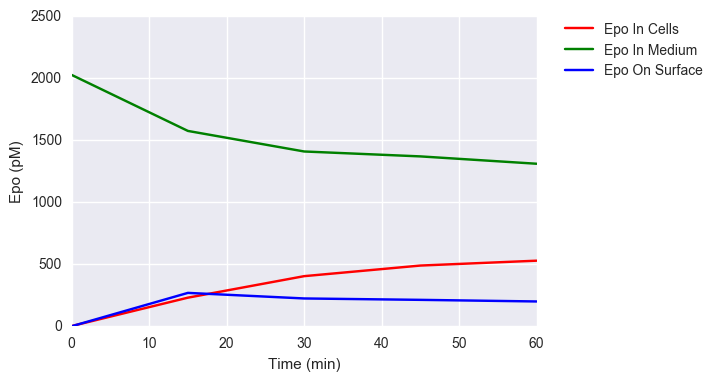

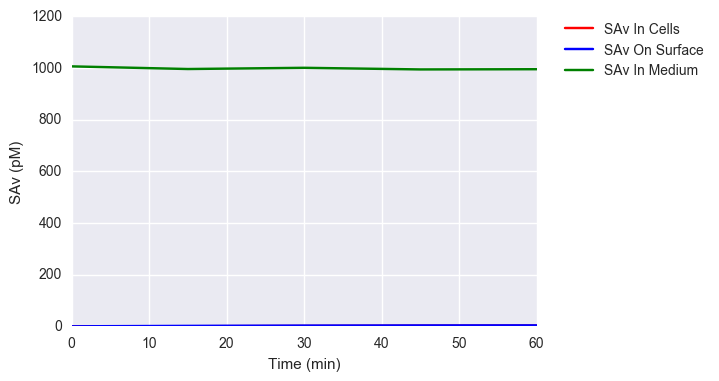

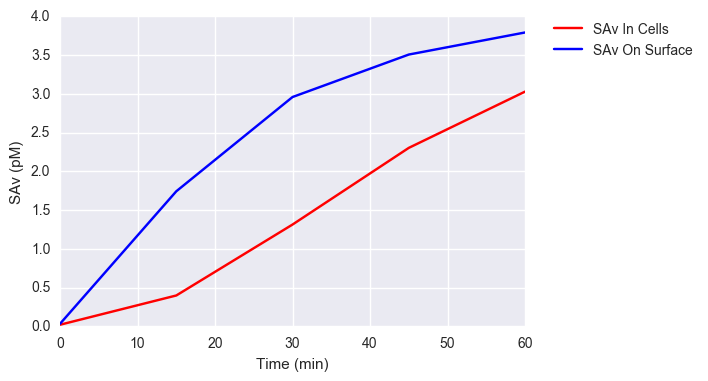

In [42]:
time = [0,15,30,45,60]
epoInCells = [2.312138728,
231.2138728,
404.6242775,
490.1734104,
529.4797688,              
]
epoInMedium = [2027.517372,
1575.832094,
1410.083737,
1370.44308,
1311.176474,
]
epoOnSurface = [0.864553314,
269.740634,
224.7838617,
213.5446686,
200.5763689,
]
SAvInCells = [0.020585878,
0.398119715,
1.313551919,
2.302700658,
3.028519456,
          
]
SAvInMedium = [1006.285664,
996.0599247,
1000.755775,
994.4899688,
995.3029816,
]
SAvOnSurface = [0.032876712,
1.742465753,
2.95890411,
3.506849315,
3.791780822,
]

d= {'EpoInCells': epoInCells, 'EpoInMedium': epoInMedium, 'EpoOnSurface': epoOnSurface}
obsEpo = pd.DataFrame(data=d, index=time)
d= {'SAvInCells': SAvInCells, 'SAvInMedium': SAvInMedium, 'SAvOnSurface': SAvOnSurface}
obsSAv = pd.DataFrame(data=d, index=time)
d= {'EpoInCells': epoInCells, 'EpoInMedium': epoInMedium, 'EpoOnSurface': epoOnSurface, 
    'SAvInCells': SAvInCells, 'SAvInMedium': SAvInMedium, 'SAvOnSurface': SAvOnSurface,
    'expSAv': [999.293],
    'expEpo': [2030.19]}
obsDF = pd.DataFrame(data=d, index=time)


plt1 = plt.plot(time,epoInCells , 'r-', label="Epo In Cells")
plt2 = plt.plot(time,epoInMedium, 'g-', label="Epo In Medium")
plt3 = plt.plot(time,epoOnSurface, 'b-', label="Epo On Surface")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('Epo (pM)')
plt.xlabel('Time (min)')
plt.show()

plt1 = plt.plot(time,SAvInCells , 'r-', label="SAv In Cells")
plt3 = plt.plot(time,SAvOnSurface, 'b-', label="SAv On Surface")
plt2 = plt.plot(time,SAvInMedium, 'g-', label="SAv In Medium")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('SAv (pM)')
plt.xlabel('Time (min)')
plt.show()

plt1 = plt.plot(time,SAvInCells , 'r-', label="SAv In Cells")
plt3 = plt.plot(time,SAvOnSurface, 'b-', label="SAv On Surface")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('SAv (pM)')
plt.xlabel('Time (min)')
plt.show()

# Maximize Posterior with Fake Data

In [32]:
#kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex
params = [0.03294,0.003179,0.01640,2.294e-6,0.0110,0.10496e-3,0.07483,0.00994]
#print len(params)
expSAv = 999.293
expEpo = 2030.19
xy0 = [Bmax,0,0,0,0,Bmax_SAv,0,0,0,0]

#m, kt,kdi,kde,kon_SAv,kex_Sav,kon,ke,kex,Epo,SAv
mcmc_params = np.append([0.5],params)
mcmc_params = np.append(mcmc_params,[expEpo,expSAv])

yca=[]
yca = np.append(xy0[0],mcmc_params[9])
yca = np.append(yca,xy0[1:6])
yca = np.append(yca,mcmc_params[10])
yca = np.append(yca,xy0[6:])

#print mcmc_params
#print model(yca, time, params)
#print log_likelihood(mcmc_params, xy0, obsDF)
#log_prior(mcmc_params)
#log_posterior(mcmc_params, xy0, obsDF)
#param_est = find_map(mcmc_params, xy0, obsDF)


In [38]:
# Guess some starting values for [alpha, T_s, T_g, m]
param_guess = [.8, 1., 1., 0.5, 0.8]
# Run optimiser
param_est = find_map(mcmc_params, xy0, obsDF)
if ERROR:
    print param_est[0]
    print
    print param_est[1]
    print
    print param_est[2]
    print
else:
    # Print results
    print '\n'
    count = 0
    for idx, param in enumerate(['m', 'kt','kdi','kde','kon_SAv','kex_Sav','kon','ke','kex','Epo','SAv']):
        print 'Estimated %s: %.15f.' % (param, param_est[idx])
        count += 1
    print count



Estimated m: 0.525000000000000.
Estimated kt: 0.032940000000000.
Estimated kdi: 0.003179000000000.
Estimated kde: 0.016400000000000.
Estimated kon_SAv: 0.000002294000000.
Estimated kex_Sav: 0.011000000000000.
Estimated kon: 0.000104960000000.
Estimated ke: 0.074830000000000.
Estimated kex: 0.009940000000000.
Estimated Epo: 2030.190000000000055.
Estimated SAv: 999.293000000000006.
11


# Define Parameters and Run MCMC Hammer with Fake Data



Average acceptance fraction:  0.230833333333


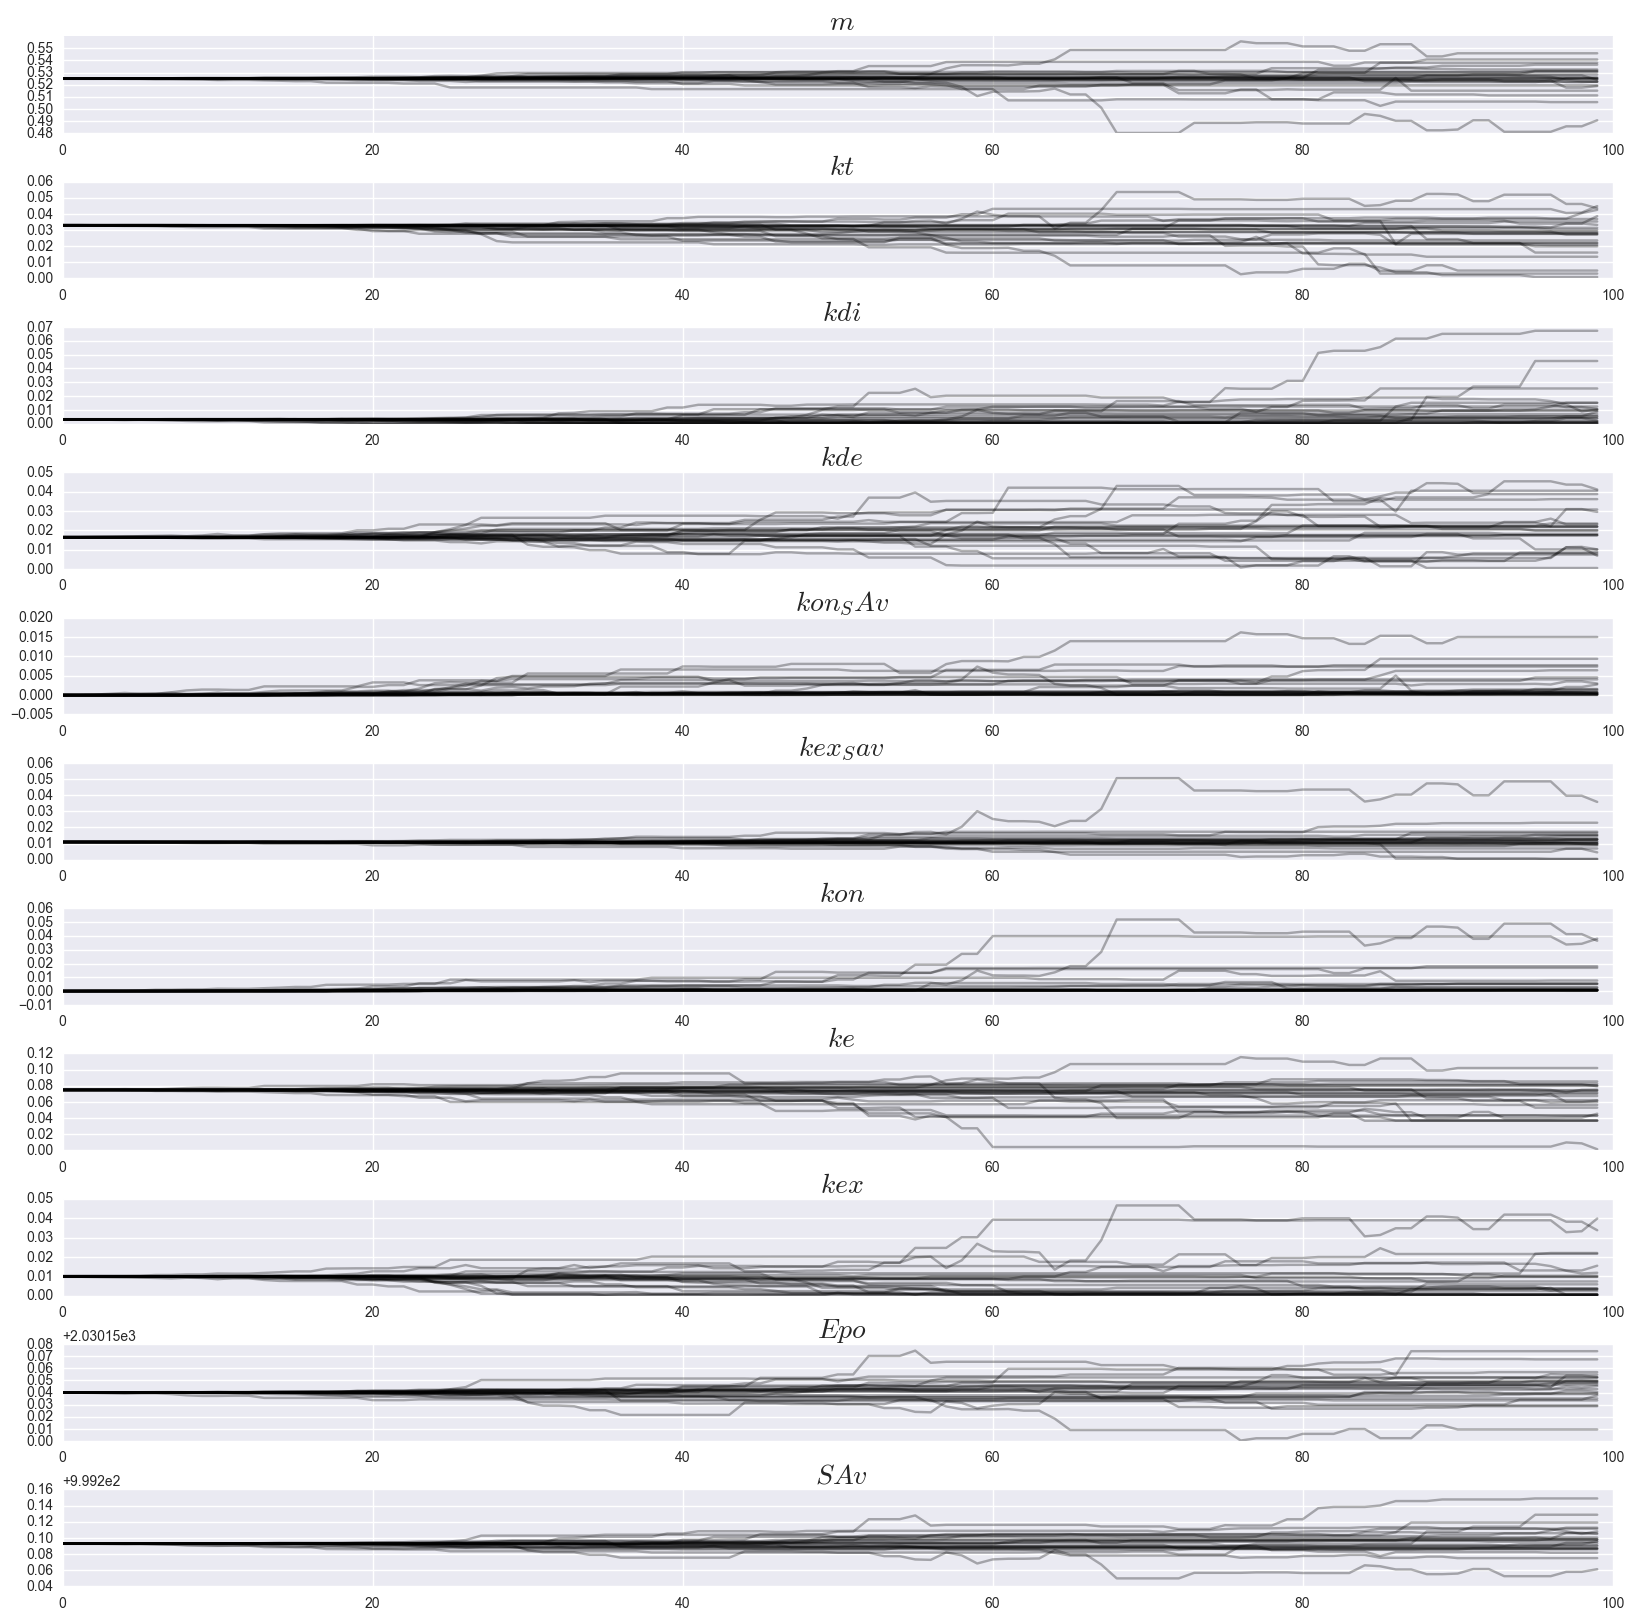

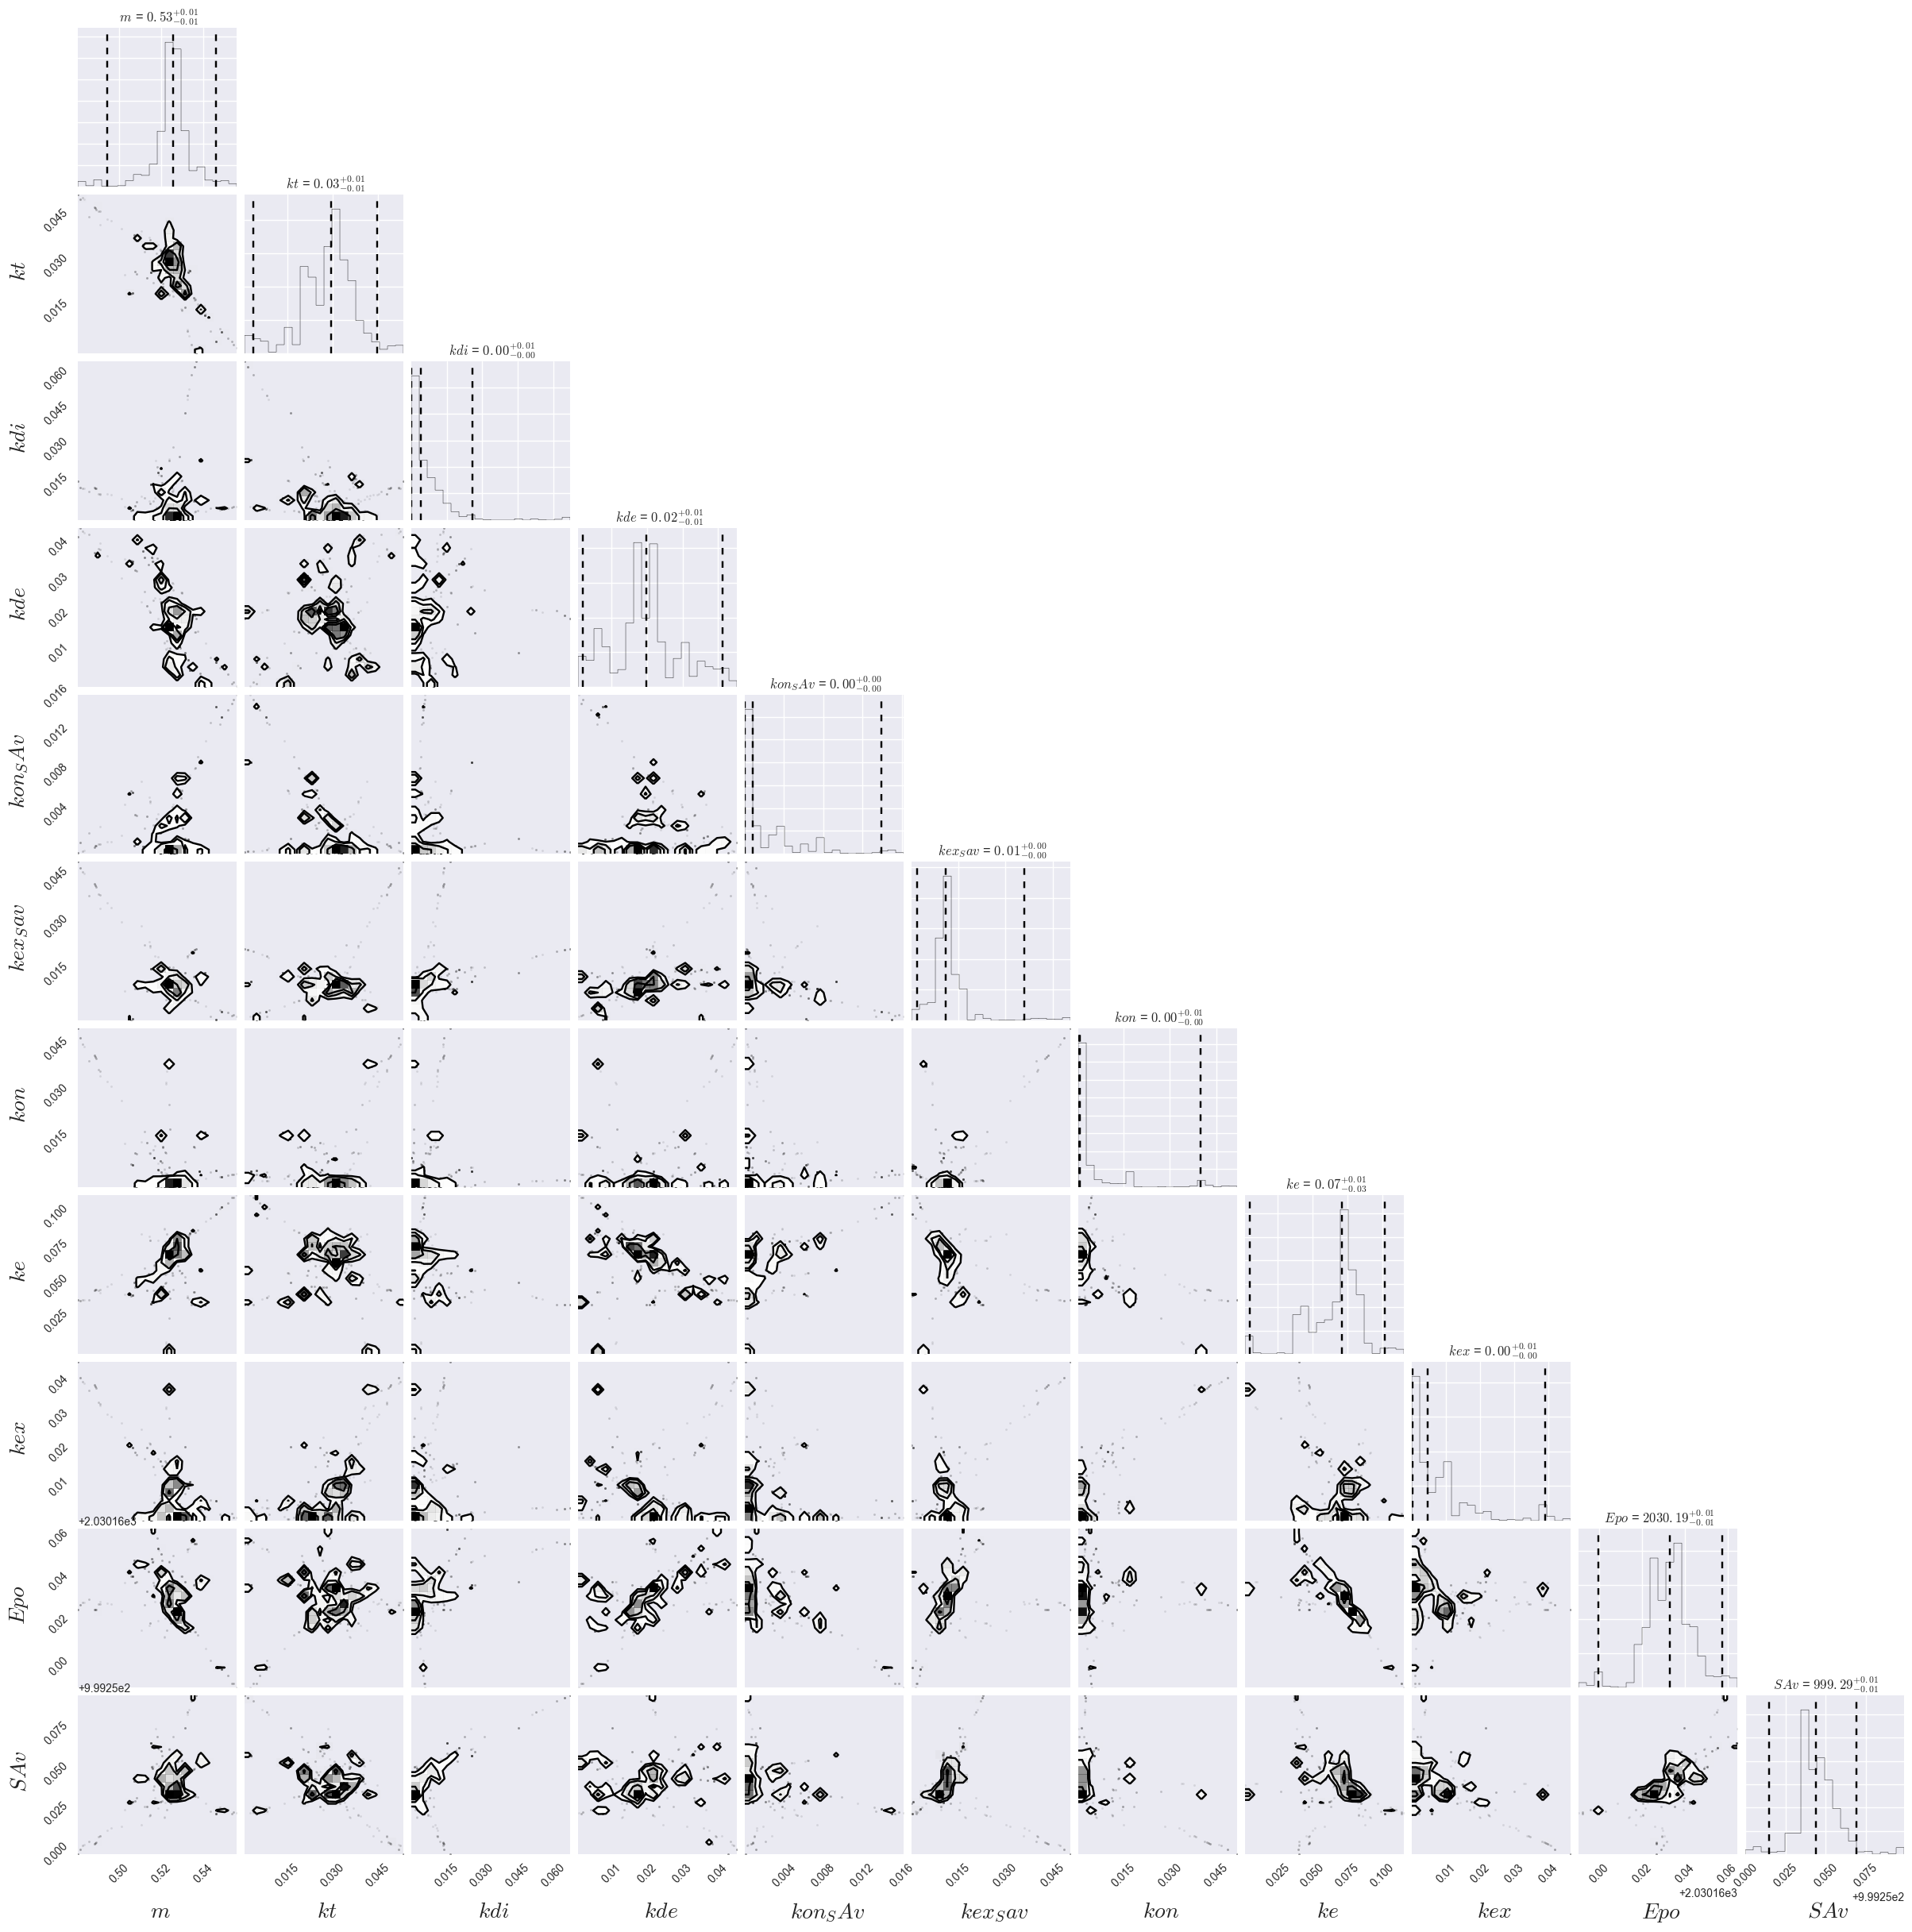

In [60]:
# emcee parameters
from scipy.integrate import odeint
ERROR = 0
n_dim = 11      # Number of parameters being calibrated
n_walk = 24    # Number of "walkers"/chains
n_steps = 100  # Number of steps per chain
n_burn = 50   # Length of burn-in to discard
samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, param_est, obsDF,xy0)

# Get Uncertainty with Fake Parameters

In [88]:
# Number of param sets to use
n_sets = 10

# Get uncertainty intervals
param_onlyEC,param_onlyEM,param_onlyES,param_onlySC,param_onlySM,param_onlySS, \
overallEC,overallEM,overallES,overallSC,overallSM,overallSS = get_uncertainty_intervals(n_sets, samples, obsDF, xy0)


In [89]:
# Plot
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(time, overallEC['2.5%'], overallEC['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(time, param_onlyEC['2.5%'], param_onlyEC['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(time,param_onlyEC['50%'], 'r-', label='Median simulated')
plt.plot(time, obsDF['EpoInCells'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('EpoInCells') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

In [90]:
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(time, overallEM['2.5%'], overallEM['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(time, param_onlyEM['2.5%'], param_onlyEM['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(time,param_onlyEM['50%'], 'r-', label='Median simulated')
plt.plot(time, obsDF['EpoInMedium'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('EpoInMedium') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

In [85]:
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(time, overallES['2.5%'], overallES['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(time, param_onlyES['2.5%'], param_onlyES['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(time,param_onlyES['50%'], 'r-', label='Median simulated')
plt.plot(time, obsDF['EpoOnSurface'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('EpoOnSurface') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

In [91]:
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(time, overallSC['2.5%'], overallSC['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(time, param_onlySC['2.5%'], param_onlySC['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(time,param_onlySC['50%'], 'r-', label='Median simulated')
plt.plot(time, obsDF['SAvInCells'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('SAvInCells') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

In [92]:
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(time, overallSM['2.5%'], overallSM['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(time, param_onlySM['2.5%'], param_onlySM['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(time,param_onlySM['50%'], 'r-', label='Median simulated')
plt.plot(time, obsDF['SAvInMedium'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('SAvInMedium') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

In [93]:
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(time, overallSS['2.5%'], overallSS['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(time, param_onlySS['2.5%'], param_onlySS['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(time,param_onlySS['50%'], 'r-', label='Median simulated')
plt.plot(time, obsDF['SAvOnSurface'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('SAvOnSurface') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

# Plot Residuals with Fake Data

In [ ]:
med = plot_residuals(samples, obs)

# Calculate Coverage with Fake Data

In [ ]:
cov = calc_coverage(med, overallH, overallL)
print 'Coverage H: %.2f' % (cov[0]*100)
print 'Coverage L: %.2f' % (cov[1]*100)

# Show Correlation Fake Data

In [ ]:
pd.tools.plotting.autocorrelation_plot(med['HErr_Std'] )

In [ ]:
pd.tools.plotting.autocorrelation_plot(med['LErr_Std'] )

# ACTUAL DATA

# Prepare ACTUAL Data

In [ ]:
#%%px --local
import matplotlib.pyplot as plt

Year = [1900 ,1901 ,1902, 1903,1904,1905,1906,1907,1908, 1909, 1910]
x=[30.0,47.2,70.2,77.4,36.3,20.6,18.1,21.4,22.0,25.4,27.1]
y=[4.0,6.1,9.8,35.2,59.4,41.7,19.0,13.0,8.3,9.1,7.4]

HL = []
HL.append(x)
HL.append(y)
HL = np.array(HL)
d= {'Hare': HL[0], 'Lynx': HL[1]}
obs = pd.DataFrame(data=d, index=Year)
plt1 = plt.plot(Year,HL[0].T , 'r-', label="Hares")
plt2 = plt.plot(Year,HL[1] , 'g-', label="Lynx")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('Population')
plt.xlabel('Year')
#plt.show()


# Experimental Data For 60 Minutes

In [1]:
epoInCells = pandas.read_csv("EpoInMedium.csv")
print epoInCells

NameError: name 'pandas' is not defined

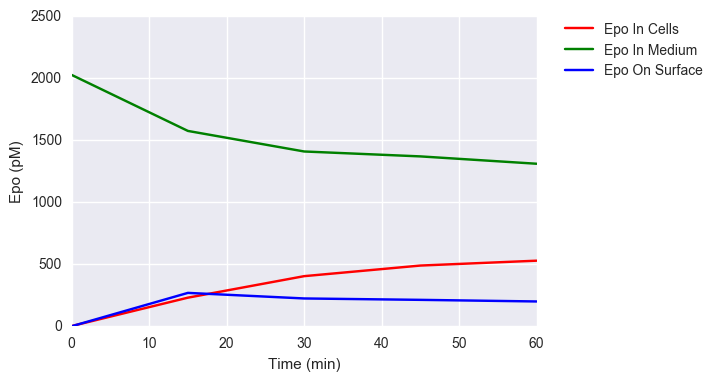

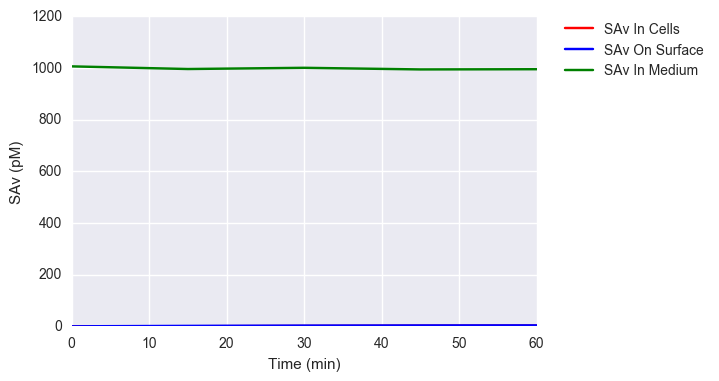

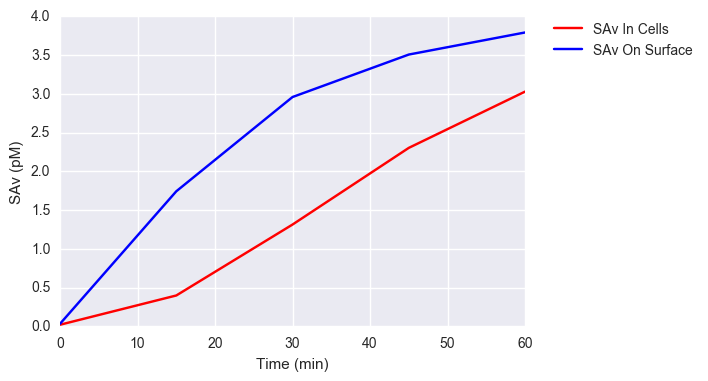

In [42]:
time = [0,15,30,45,60]
epoInCells = pandas.read_csv("EpoInMedium.csv")
print epoInCells
epoInMedium = [2027.517372,
1575.832094,
1410.083737,
1370.44308,
1311.176474,
]
epoOnSurface = [0.864553314,
269.740634,
224.7838617,
213.5446686,
200.5763689,
]
SAvInCells = [0.020585878,
0.398119715,
1.313551919,
2.302700658,
3.028519456,
          
]
SAvInMedium = [1006.285664,
996.0599247,
1000.755775,
994.4899688,
995.3029816,
]
SAvOnSurface = [0.032876712,
1.742465753,
2.95890411,
3.506849315,
3.791780822,
]

d= {'EpoInCells': epoInCells, 'EpoInMedium': epoInMedium, 'EpoOnSurface': epoOnSurface}
obsEpo = pd.DataFrame(data=d, index=time)
d= {'SAvInCells': SAvInCells, 'SAvInMedium': SAvInMedium, 'SAvOnSurface': SAvOnSurface}
obsSAv = pd.DataFrame(data=d, index=time)
d= {'EpoInCells': epoInCells, 'EpoInMedium': epoInMedium, 'EpoOnSurface': epoOnSurface, 
    'SAvInCells': SAvInCells, 'SAvInMedium': SAvInMedium, 'SAvOnSurface': SAvOnSurface,
    'expSAv': [999.293],
    'expEpo': [2030.19]}
obsDF = pd.DataFrame(data=d, index=time)


plt1 = plt.plot(time,epoInCells , 'r-', label="Epo In Cells")
plt2 = plt.plot(time,epoInMedium, 'g-', label="Epo In Medium")
plt3 = plt.plot(time,epoOnSurface, 'b-', label="Epo On Surface")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('Epo (pM)')
plt.xlabel('Time (min)')
plt.show()

plt1 = plt.plot(time,SAvInCells , 'r-', label="SAv In Cells")
plt3 = plt.plot(time,SAvOnSurface, 'b-', label="SAv On Surface")
plt2 = plt.plot(time,SAvInMedium, 'g-', label="SAv In Medium")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('SAv (pM)')
plt.xlabel('Time (min)')
plt.show()

plt1 = plt.plot(time,SAvInCells , 'r-', label="SAv In Cells")
plt3 = plt.plot(time,SAvOnSurface, 'b-', label="SAv On Surface")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend([plt1[0],plt2[0],plt3[0],plt4[0]], ["Obs x1","Obs x2","Obs x3","Obs x4"],loc=1)
plt.ylabel('SAv (pM)')
plt.xlabel('Time (min)')
plt.show()

# Maximize Posterior with ACTUAL Data

In [ ]:
# Guess some starting values for [alpha, T_s, T_g, m]
#param_guess = [.8, 1., 1., 0.5, 0.8]
param_guess = [0.54, 0.01, 9.56, 0.31, 1]
# Run optimiser
param_est = find_map(param_guess, xy0, obs)
if ERROR:
    print param_est[0]
    print
    print param_est[1]
    print
    print param_est[2]
    print
else:
    # Print results
    print '\n'
    for idx, param in enumerate(['a','b','r','c','m']):
        print 'Estimated %s: %.2f.' % (param, param_est[idx])

# Define Parameters and Run MCMC Hammer with ACTUAL Data

In [ ]:
# emcee parameters
n_dim = 5      # Number of parameters being calibrated
n_walk = 20    # Number of "walkers"/chains
n_steps = 200  # Number of steps per chain
n_burn = 100   # Length of burn-in to discard
samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, param_est, obs)

# Get Uncertainty with ACTUAL Parameters

In [ ]:
# Number of param sets to use
n_sets = 10

# Get uncertainty intervals
param_onlyH, overallH, param_onlyL, overallL = get_uncertainty_intervals(n_sets, samples, obs)

# Plot
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(Year, overallH['2.5%'], overallH['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(Year, param_onlyH['2.5%'], param_onlyH['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(Year,param_onlyH['50%'], 'r-', label='Median simulated')
plt.plot(Year, obs['Hare'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('Hare') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

In [ ]:
# Plot
fig = plt.figure()

# 95% credible interval for overall predictive uncertainty
plt.fill_between(Year, overallL['2.5%'], overallL['97.5%'], color='r', alpha=0.3)

# Overaly 95% credible interval for parameter-related uncertainty
plt.fill_between(Year, param_onlyL['2.5%'], param_onlyL['97.5%'], color='r', alpha=0.3)

# Median of simulated and observed
plt.plot(Year,param_onlyL['50%'], 'r-', label='Median simulated')
plt.plot(Year, obs['Lynx'].values , 'k-', label='Observed')
leg = plt.legend(loc='best')
leg.set_title('Lynx') # Hack to get around display issue in mpld3/matplotlib
                  # (see https://github.com/jakevdp/mpld3/issues/275)
mpld3.display()

# Plot Residuals with ACTUAL Data

In [ ]:
med = plot_residuals(samples, obs)

# Calculate Coverage with ACTUAL Data

In [ ]:
cov = calc_coverage(med, overallH, overallL)
print 'Coverage H: %.2f' % (cov[0]*100)
print 'Coverage L: %.2f' % (cov[1]*100)

# Show Correlation ACTUAL Data

In [ ]:
pd.tools.plotting.autocorrelation_plot(med['HErr_Std'] )

In [ ]:
pd.tools.plotting.autocorrelation_plot(med['LErr_Std'] )

# Your score on this proble is 30/30.